In [1]:
%matplotlib inline
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
import time
from numba import jit

In [5]:
def sparsePDMatrix(Nx,sparseness):
    # Generate a sparse random symmetric matrix of size Nx by Nx
    J = np.tril(np.random.randn(Nx,Nx),k=-1)
    J = (J + J.T)/2 + np.diag(np.abs(np.random.randn(Nx))) # make a symmetric J
    
    # create the mask for zeros
    H = np.random.rand(Nx,Nx)   # Sparse selection matrix
    H = np.tril(H,k=-1)         # make diagonal and upper triangle of the matrix zero
    H[H < sparseness] = 0
    H[H >= sparseness] = 1
    H = H + H.T + np.eye(Nx) # elements of H which are 1 will be retained in J
    
    J = np.multiply(J,H)

    eps = 0.1
    mineigval = min(np.linalg.eigvals(J))
    J = J - np.diag(mineigval*np.ones(Nx) - eps)
    
    return J

def powersofJ(J,P):
    Nx = np.shape(J)[0]
    J_p = np.ones([Nx,Nx,P+1])
    
    for ii in range(P+1):
        J_p[:,:,ii] = J**ii
    
    return J_p
        

def sigmoid(x):
    return 1/(1+np.exp(-x))

@jit
def TAPF(xt,ht,J_p,G):
    
    Nx = np.shape(xt)[0]
    
    
    # Here we are assuming the indices a,b,c in G_abc are in {0,1,2}
    
    # LUT for indices
    LUT = np.array([[0,0,0],[0,0,1],[0,0,2],[0,1,0],[0,1,1],[0,1,2],[0,2,0],[0,2,1],[0,2,2],[1,0,0],[1,0,1],[1,0,2],[1,1,0],[1,1,1],[1,1,2],[1,2,0],[1,2,1],[1,2,2],[2,0,0],[2,0,1],[2,0,2],[2,1,0],[2,1,1],[2,1,2],[2,2,0],[2,2,1],[2,2,2]])
    
    # Powers of JMat and xt
    xt_p = np.ones([Nx,3])
    
    for ii in range(3):
        xt_p[:,ii] = xt**ii
        
        
    Ng = len(G)
    
    Im1Mat = np.zeros([Nx,Ng])
    Im2Mat = np.zeros([Nx,Ng])
    EtaMat = np.zeros([Nx,Nx,Ng])

    
    for ii in range(Ng):
        
        a = LUT[ii,0]
        b = LUT[ii,1]
        c = LUT[ii,2]
        Ja = J_p[:,:,a]
        xb = xt_p[:,b]
        xc = xt_p[:,c]
        
        Im1Mat[:,ii] = xb*np.dot(Ja,xc)
        Im2Mat[:,ii] = G[ii]*Im1Mat[:,ii]
        
        if ii > 8:
            outerprod = np.dot(np.expand_dims(xb, 1), np.expand_dims(xc, 1).T)
            EtaMat[:,:,ii] = G[ii]*a*J_p[:,:,a-1]*outerprod
            
    argf = np.sum(Im2Mat,axis=1) + ht
    out  = sigmoid(argf)
    
    EtaMat = np.sum(EtaMat,axis=2)
        
    return out,argf,Im1Mat,EtaMat
    
@jit
def runTAP(x0, hMat, lam, Qpr, Qobs, U, J, G):
    T = np.shape(hMat)[1]
    J_p = powersofJ(J,2)
    Nx = len(x0)
    
    xMat = np.zeros([Nx,T])
    xold = x0
    
    for tt in range(T):
        ht = hMat[:,tt]
        out, arfg = TAPF(xold, ht, J_p, G)[0:2]
        xnew = (1-lam)*xold + lam*out
        
        xMat[:,tt] = xnew + np.random.multivariate_normal(np.zeros(Nx),Qpr,1).flatten()
        xold = xnew
    
    
    Nr   = np.shape(U)[0]
    rMat = np.dot(U,xMat) + np.random.multivariate_normal(np.zeros(Nr),Qobs,T).T
        
    return xMat,rMat

def generateH(Nx,T,Nh,scaling):
    hInd = scaling*np.random.randn(Nx,int(np.ceil(T/Nh)))
    hMat = np.zeros([Nx,T])
    for tt in range(T):
        hMat[:,tt] = hInd[:,int(np.floor(tt/Nh))]
    return hMat

In [13]:
Nx = 3
Nr = 6
T  = 200
Nh = 30 
lam = 0.25

sp = 0.5
gj = 4/Nx
J = gj*sparsePDMatrix(Nx,sp)

G = [0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]

U = np.random.randn(Nr,Nx)

# generate inputs
gh = 1
hMat = generateH(Nx,T,Nh,gh)

Qpr  = 0e-4*np.eye(Nx)
Qobs = 4e-4*np.eye(Nr)

# initial values for the TAP dynamics
x0 = np.random.rand(Nx)

# generate the latent dynamics and observations
xMat, rMat = runTAP(x0, hMat, lam, Qpr, Qobs, U, J, G)

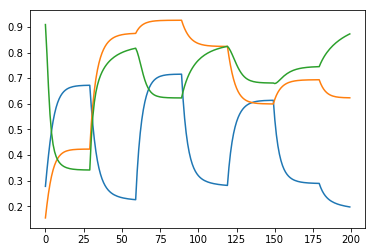

In [14]:
plt.plot(xMat.T)
plt.show()

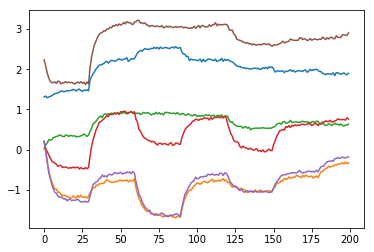

In [15]:
plt.plot(rMat.T)
plt.show()